In [ ]:
#Importing all the required librabries, classifiers etc.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import time
%matplotlib inline

In [ ]:
#mounting the google drive to content to the data base
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


#Change the drive location here for the location of the files in your dataset

In [ ]:
cd gdrive/MyDrive/Colab Notebooks/Assignment1 

/content/gdrive/MyDrive/Colab Notebooks/Assignment1


In [ ]:
import os
print(os.listdir("./Input/train"))
pd.set_option('display.max_columns', 10) #locating the input data folder


['train.csv']


In [ ]:
data_train_df = pd.read_csv('./Input/train/train.csv') #obtaining the input data


#**Data Pre-processing**

In [ ]:
data_train_df.head()
print(len(data_train_df)) #checking the length of the input data 

30000


In [ ]:
# Selecting train input feature
input_feature = data_train_df.loc[:, "v1":"v784"].to_numpy()
# Selecting train input label
input_label = data_train_df.label.to_numpy()
print(input_feature)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


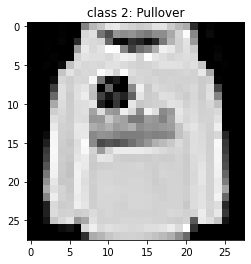

In [ ]:
#displaying a random image from the dataset with its label
input_feature = input_feature.reshape((input_feature.shape[0],28, 28))
plt.imshow(input_feature[0], cmap=plt.get_cmap('gray'))
plt.title("class " + str(input_label[0]) + ": Pullover" )
plt.show() 

In [ ]:
# test_input.csv includes 5000 samples used for label prediction. Test samples do not have labels.
data_test_df = pd.read_csv('./Output/test/test_input.csv')


In [ ]:
output_feature=data_test_df
output_feature.head() #note this data has no labels

,id,v1,v2,v3,v4,...,v780,v781,v782,v783,v784
0,0,0,0,0,0,...,0,0,0,0,0
1,1,0,0,0,0,...,0,0,0,0,0
2,2,0,0,0,0,...,0,0,0,0,0
3,3,0,0,0,0,...,0,0,0,0,0
4,4,0,0,0,0,...,0,0,0,0,0


In [ ]:
#Selecting test data output features
output_data_test = data_test_df.loc[:, "v1":"v784"].to_numpy()

In [ ]:
input_feature = input_feature.reshape(30000, -1) #reshaping the input data

Since the test data provided doesnot contain labels for the purpose of checking the accuracy of the model I have split the training data using train_test_split into 75% training data and 25% test data. 
Therefore from now the training data size would be (22500)
testing data* size would be (7500).

*note: The actual testing data (5000) with no labels will be used at the end after checking the accuracy of the classifiers on the training data set. The output labels for the final test data will be obtained at the end.


In [ ]:
#spliting the training data into train and test 
train_feature,test_feature,train_label,test_label = train_test_split(
    input_feature, input_label, random_state=0)

In [ ]:
print(len(test_feature))

7500


###**Principal Component Analysis(PCA)**

In [ ]:
features = train_feature.T
covariance_matrix = np.cov(features)

eig_value, eig_vector = np.linalg.eig(covariance_matrix)

print('Total No. of eigen values ')
print(eig_value.shape)
sum(eig_value[0:350])/sum(eig_value)
len(eig_value)
eig_pairs = [(np.abs(eig_value[i]), eig_vector[:,i]) for i in range(len(eig_value))]
#sorting te=he eigen values
eig_pairs.sort()
eig_pairs.reverse()

#creating a stack of 350 features that have maximum weight
matrix_w=eig_pairs[0][1].reshape(784,1)
for i in range(1,350):
  a = eig_pairs[i][1].reshape(784,1)
  matrix_w = np.hstack((matrix_w, a))
  
#tranforming the train and test data using pca
data_train_pca = train_feature.dot(matrix_w)
data_test_pca = test_feature.dot(matrix_w)
output_data_test_pca = output_data_test.dot(matrix_w)


Total No. of eigen values 
(784,)


In [ ]:
print('Size of new Projection :')
print(matrix_w.shape)
print('Size of new training feature data with PCA matrix:')
print(data_train_pca.shape)
print('Size of new testing feature data with PCA matrix:')
print(data_test_pca.shape)
print('Size of new final output testing feature data with PCA matrix:')
print(output_data_test_pca.shape)

train_feature = data_train_pca
test_feature = data_test_pca
output_data_test = output_data_test_pca

Size of new Projection :
(784, 350)
Size of new training feature data with PCA matrix:
(22500, 350)
Size of new testing feature data with PCA matrix:
(7500, 350)
Size of new final output testing feature data with PCA matrix:
(5000, 350)


#**(kNN) K-Nearest Neighbours Classifier**

In [ ]:
class knn_funct():
    #creating knn classifier with L2 distance

    def __init__(self):
        pass
    def train_funct(self, X, Y): #define train function
        self.train_feature = X
        self.train_label= Y
    def compute_distance(self, X): #define distance computation function
        num_test = X.shape[0]
        num_train = self.train_feature.shape[0]
        dot_pro = np.dot(X, self.train_feature.T)
        sum_square_test = np.square(X).sum(axis = 1)
        sum_square_train = np.square(self.train_feature).sum(axis = 1)
        
        distance = np.sqrt(-2 * dot_pro + sum_square_train + np.matrix(sum_square_test).T)

        return(distance)
      
    def predict_funct(self, X, k): #define prediction function
        distance = self.compute_distance(X)
        num_test = distance.shape[0]
        y_predicted = np.zeros(num_test)

        for i in range(num_test):
            k_closest_y = []
            labels = self.train_label[np.argsort(distance[i,:])].flatten()
            # find k nearest lables
            k_closest_Y = labels[:k]
            c1 = Counter(k_closest_Y)
            y_predicted[i] = c1.most_common(1)[0][0]

        return(y_predicted)

def knn_predict(test_feature, batch_size): #creating a knn prediction function on recieving user input

  predictions = []

  for i in range(int(len(test_feature)/(2*batch_size))):
      # predicts from i * batch_size to (i+1) * batch_size
      predts = classifier.predict_funct(test_feature[i * batch_size:(i+1) * batch_size], k)
      predictions = predictions + list(predts)
  
    # To predict second half of test data

  for i in range(int(len(test_feature)/(2*batch_size)), int(len(test_feature)/batch_size)):
      #predicts from i * batch_size to (i+1) * batch_size
      predts = classifier.predict_funct(test_feature[i * batch_size:(i+1) * batch_size], k)
      predictions = predictions + list(predts)


  y_new = np.asarray(predictions)
  return y_new      

#**Naive Bayes Classifier**

In [ ]:
class Naive_Bayes(object):
    def __init__(self, learning_rate= 0.001):
        self.learning_rate = learning_rate 

    def nb_train(self, X, Y): #define the train function for the nvb classifier
        sample_count = X.shape[0]
        sep = [[x for x, p in zip(X, Y) if p == n] for n in np.unique(Y)]
        self.log_prior_class = [np.log(len(i) / sample_count) for i in sep]
        count_arr = np.array([np.array(i).sum(axis=0) for i in sep]) + self.learning_rate
        self.log_prob_feature = np.log(count_arr / count_arr.sum(axis=1)[np.newaxis].T)
        return self

    def nb_predict(self, X): #nb prediction by using the log-likelihood notation 
        return [(self.log_prob_feature * a).sum(axis=1) + self.log_prior_class for a in X]

    def predict_nb(self, X): #nb prediction function
        return np.argmax(self.nb_predict(X), axis=1)

#**Support Vector Machine Classifier**

In [ ]:
# Linear SVM
def linear_SVM(X,y_train,X_test,y_test): #define Linear SVM classifier function
  scaler = MinMaxScaler()
  scaler.fit(X)
  X_train = scaler.transform(X) 
  X_test = scaler.transform(X_test) 
  
  lin_svm = SVC(kernel="linear")
  lin_svm.fit(X_train, y_train)
  y_pred = lin_svm.predict(X_test)
  return y_pred
 

# RBF SVM
def rbf_SVM(X,y_train,X_test): #define RBF based SVM classifier function
  scaler = MinMaxScaler()
  scaler.fit(X)
  X_train = scaler.transform(X) 
  X_test = scaler.transform(X_test) 
  rbf_svm = SVC(kernel="rbf", gamma="auto")
  rbf_svm.fit(X_train, y_train)
  y_pred = rbf_svm.predict(X_test)
  return y_pred


#**Ensemble Method: Random Forest Classifier**

In [ ]:
def rf_train(X,Y,X_test): #define a function for random forest classifier
      rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
      rnd_clf.fit(X,Y)
      y_pred_rf = rnd_clf.predict(X_test)
      return y_pred_rf
   

#**Parameter Grid Search using 10-fold cross validation for KNN Classifier**
Hyperparameter tunning using grid search

In [ ]:
# param_grid = {'n_neighbors': [1, 3, 5, 11, 15],
#               'p': [1, 2]}
# print("Parameter grid:\n{}".format(param_grid))

# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10,
#                           return_train_score=True)


# grid_search.fit(train_feature, train_label)

# print("Test set score: {:.2f}".format(grid_search.score(test_feature,test_label)))
# print("Best parameters: {}".format(grid_search.best_params_))
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
# print("Best estimator:\n{}".format(grid_search.best_estimator_))

#output
# Parameter grid:
# {'n_neighbors': [1, 3, 5, 11, 15], 'p': [1, 2]}
# Test set score: 0.84
# Best parameters: {'n_neighbors': 5, 'p': 2}
# Best cross-validation score: 0.84
# Best estimator:
# KNeighborsClassifier()

#time taken(3h 27m 18s)

#**Input Classifier Selection**

In [ ]:
print("Enter your chocice of classifier from 1 to 4:") #allowing the user to pick a classifier of their choice
print("1. K Nearest Neighbour Classifier")
print("2. Naive Bayes Classifier")
print("3. Support Vector Machine(svm) Classifier ")
print("4. Random Forest Classifier")
print()
user_input=int(input("Enter your choice here: "))

t1=time.time()

if user_input is 1:
  batch_size = 1000
  #k=1 is not considered due to overfitting and the other values of K provide less accuracy
  k = 3
  classifier = knn_funct()
  classifier.train_funct(train_feature, train_label)
  predictions=knn_predict(train_feature,batch_size)
  print("For k:",k )
  print("Accuracy of model on train set:",accuracy_score(train_label[0:22000],predictions)*100) #accuracy on train set
  predictions=knn_predict(test_feature,batch_size)
  print("Accuracy of model on test set:",accuracy_score(test_label[0:7000], predictions)*100) #accuracy on test set
  output = knn_predict(output_data_test,batch_size) #generating the output file using the actual test data. note: output_data_test is the test data without labels(5000)


elif user_input is 2:
  model = Naive_Bayes()
  model.nb_train(train_feature,train_label)
  predictions = model.predict_nb(train_feature)
  print("Accuracy of model on training set:",accuracy_score(predictions, train_label)*100) #accuracy on train set
  predictions = model.predict_nb(test_feature)
  print("Accuracy of model on test set:",accuracy_score(predictions,test_label)*100) #accuracy on test set
  output = model.predict_nb(output_data_test) #generating the output file using the actual test data. note: output_data_test is the test data without labels(5000)



elif user_input is 3:
  predictions = linear_SVM(train_feature, train_label, train_feature,train_label)
  print("Linear SVM  accuracy on train set: ",(accuracy_score(train_label, predictions))*100) #accuracy on train set(linear SVM)
  predictions = linear_SVM(train_feature, train_label, test_feature,test_label)
  print("Linear SVM  accuracy on test set: ",(accuracy_score(test_label, predictions))*100) #accuracy on test set (linear SVM)
  predictions = rbf_SVM(train_feature, train_label, train_feature)
  print("RBF SVM  accuracy on train set:",(accuracy_score(train_label, predictions))*100) #accuracy on train set (SVM WITH rbf)
  predictions = rbf_SVM(train_feature, train_label, test_feature)
  print("RBF SVM  accuracy on test set: ",(accuracy_score(test_label, predictions))*100) #accuracy on test set (SVM WITH rbf)
  output = rbf_SVM(train_feature, train_label,output_data_test) #generating the output file using the actual test data. note: output_data_test is the test data without labels(5000)

  
elif user_input is 4:
  
  predictions = rf_train(train_feature,train_label,train_feature)
  print("Accuracy of model on training set:",accuracy_score(train_label,predictions)*100) #accuracy on train set
  predictions = rf_train(train_feature,train_label,test_feature)
  print("Accuracy of model on test set:",accuracy_score(test_label,predictions)*100) #accuracy on test set
  output = rf_train(train_feature,train_label,output_data_test) #generating the output file using the actual test data. note: output_data_test is the test data without labels(5000)

t2=time.time()

print()
print("Total time taken (min): " + str((t2-t1)/60) ) #calculating the time taken in minutes



#Enter 1 for KNN Classifier
#KNN classifier provides the best accuracy score in the least time
#Final Output file submitted is based on KNN Classifier 











Enter your chocice of classifier from 1 to 4:
1. K Nearest Neighbour Classifier
2. Naive Bayes Classifier
3. Support Vector Machine(svm) Classifier 
4. Random Forest Classifier



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#**Generating output**

In [ ]:
output_df = pd.DataFrame(output, columns = ['label'])
output_df.to_csv('./Output/test_output.csv', sep=",", float_format='%d',index_label="id")
